In [1]:
# !pip install tifffile[all]
# !pip install opencv-python

In [2]:
import tifffile
import json
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [3]:
def imshow(image):
    plt.imshow(image)
    plt.show()

# Hàm vẽ polygon
def draw_polygon(image, polygon, color, fill = False):
    pts = np.array(list(polygon.exterior.coords), np.int32)
    pts = pts.reshape((-1, 1, 2))
    if not fill:
        cv2.polylines(image, [pts], isClosed=True, color=color, thickness=2)
    else:
        cv2.fillPoly(image, [pts], color=color, lineType=cv2.LINE_AA)
    return image

# Hàm vẽ LineString
def draw_linestring(image, linestring, color):
    pts = np.array(list(linestring.coords), np.int32)
    for i in range(len(pts) - 1):
        cv2.line(image, tuple(pts[i]), tuple(pts[i+1]), color=color, thickness=2)
    return image
# prompt: hãy vẽ polygon trên trên vào ảnh img
import random
def random_color():
  """
  Generates a random RGB color.
  """
  red = random.randint(0, 255)
  green = random.randint(0, 255)
  blue = random.randint(0, 255)
  return (red, green, blue)
    

In [4]:
all_data = json.loads(open('/home/toi/myproject/submission.json').read())

In [5]:
all_data.keys()

dict_keys(['images'])

In [6]:
for data in all_data["images"][:1]:
    filename = data["file_name"]
    seg = data["annotations"][0]["segmentation"]
    image = tifffile.imread("/home/toi/myproject/test_images/images/test_0.tif")
    img = cv2.normalize(image[:,: , 1:4], None, 0, 255, cv2.NORM_MINMAX, ).astype(np.uint8)
    print(filename)

test_0.tif


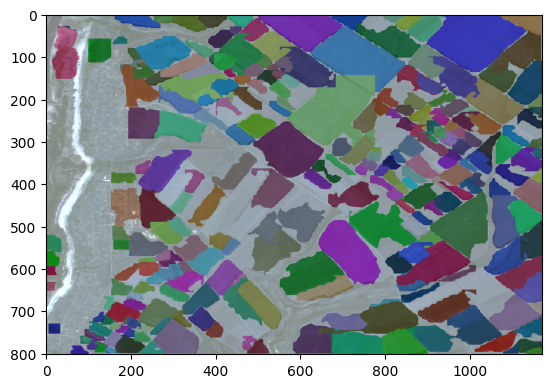

In [7]:
img_with_polygon = np.zeros_like(img)+255
for sg in data["annotations"]:
  segmentation = sg["segmentation"]
  segmentation_array = np.array(segmentation, dtype=np.int32)
  segmentation_array = segmentation_array.reshape((-1, 2))
  cv2.fillPoly(img_with_polygon, [segmentation_array], random_color())

add_wieght = cv2.addWeighted(img, 0.9, img_with_polygon, 0.5, 0)
imshow(add_wieght)



In [8]:
segmentation_array.shape

(148, 2)

In [9]:
from shapely.geometry import Polygon
from shapely.strtree import STRtree

# Ví dụ về hai polygon overlap
polygons = [] 
for sg in data["annotations"]:
    segmentation = sg["segmentation"]
    segmentation_array = np.array(segmentation, dtype=np.int32)
    segmentation_array = segmentation_array.reshape((-1, 2))
    # if len(segmentation_array.tolist()) < 5:
    #     print(segmentation_array.tolist())
    polygons.append(Polygon(segmentation_array.tolist()))

polygon_info = []


tree = STRtree(polygons)
overlaps = []

for index, polygon in enumerate(polygons):
    possible_overlaps_indices = tree.query(polygon)  # Tìm các chỉ số polygon có thể overlap
    for idx in possible_overlaps_indices:
        other = polygons[idx]  # Lấy polygon từ chỉ số
        if polygon != other:  # Loại bỏ chính polygon đó
            overlap = polygon.intersection(other)
            if not overlap.is_empty:
                overlaps.append(overlap)
                polygon_info.append((index, idx, overlap))
# print("All overlaps:")
# for overlap in overlaps:
#     print(overlap)


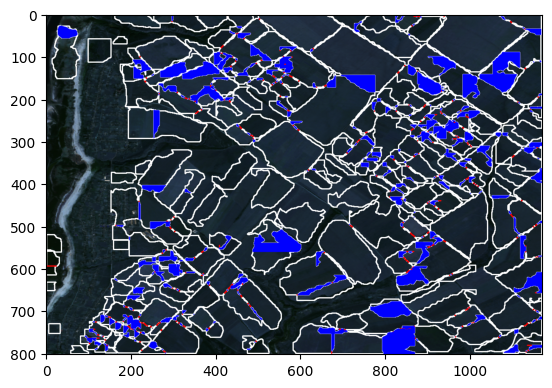

In [10]:
#  Before filter
from shapely.geometry import Polygon, LineString, GeometryCollection, MultiPolygon, MultiLineString

image = img.copy()
for poly in polygons:
    image = draw_polygon(image, poly, (255, 255, 255))  # Màu xanh dương
    
for overlap in overlaps:
    # Vẽ các thành phần của GeometryCollection
    if isinstance(overlap, GeometryCollection):
        for geom in overlap.geoms:
            if isinstance(geom, Polygon):
                draw_polygon(image, geom, (0, 0, 255), True)  
            elif isinstance(geom, LineString):
                draw_linestring(image, geom, (255, 0, 0)) 
    else:
        if isinstance(overlap, Polygon):
            draw_polygon(image, overlap, (0, 0, 255), True)  
        elif isinstance(overlap, LineString):
            draw_linestring(image, overlap, (255, 0, 0))  

imshow(image)

In [11]:
# Hàm tính khoảng cách Euclidean

def get_only_polygon(polygon):
    if isinstance(polygon, MultiPolygon):
        # If it's a MultiPolygon, get the largest polygon by area
        largest_poly = max(polygon.geoms, key=lambda poly: poly.area)
        return largest_poly 
    
    elif isinstance(polygon, LineString):
        return None
    
    elif isinstance(polygon, GeometryCollection):
        result = []
        for geom in polygon.geoms:
            result.append(get_only_polygon(geom))
        
        
        for rs in result.copy():
            if rs == None:
                result.remove(None)
                
        largest_poly = max(result, key=lambda poly: poly.area)
        
    else:
        return polygon
    
    
import math
def euclidean_distance(point1, point2):
    return math.sqrt((point1.x - point2.x) ** 2 + (point1.y - point2.y) ** 2)
def separate_polygon(polygon1, polygon2):
    polygon1 = get_only_polygon(polygon1)
    polygon2 = get_only_polygon(polygon2)
    
    if polygon1 == None or polygon2 == None:
        return None, None
    
    overlap = polygon1.intersection(polygon2)
    if isinstance(overlap, MultiLineString):
        return None, None
    centroid1 = polygon1.centroid
    centroid2 = polygon2.centroid
    overlap_centroid = overlap.centroid
    
    try:
        # Tính khoảng cách giữa centroid của overlap và centroid của hai polygon
        distance_to_polygon1 = euclidean_distance(overlap_centroid, centroid1)
        distance_to_polygon2 = euclidean_distance(overlap_centroid, centroid2)
    except:
        return None, None
    
    # union = polygon1.union(polygon2)
    if distance_to_polygon1 <= distance_to_polygon2:
        polygon2 = polygon2.difference(polygon1)
        # print("Overlap belongs to Polygon 1")
    else:
        polygon1 = polygon1.difference(polygon2)
        # print("Overlap belongs to Polygon 2")
    return polygon1, polygon2
    
# polygon1.difference(polygon2)

In [12]:
polygons_debug = polygons.copy()

<class 'shapely.geometry.polygon.Polygon'> <class 'shapely.geometry.polygon.Polygon'>
127 201
TopologyException: unable to assign free hole to a shell at 502 520
<class 'shapely.geometry.polygon.Polygon'> <class 'shapely.geometry.polygon.Polygon'>
201 127
TopologyException: unable to assign free hole to a shell at 502 520


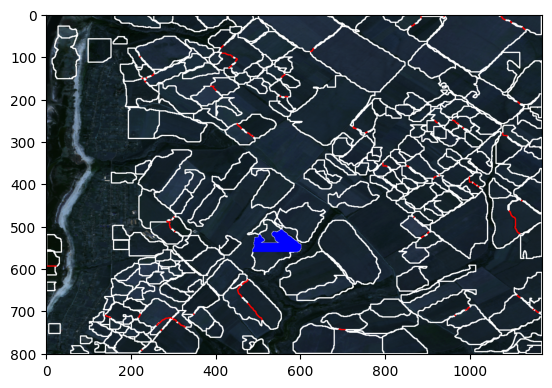

In [13]:
#after filter
image = img.copy()
for polygon_index1, polygon_index2, overlap in polygon_info.copy():
    try:
        polygon1, polygon2 = separate_polygon(polygons[polygon_index1], polygons[polygon_index2])
        if polygon1 == None or polygon2 == None:
            continue
        polygons[polygon_index1] = polygon1
        polygons[polygon_index2] = polygon2
    except Exception as e:
        print(type(polygons[polygon_index1]), type(polygons[polygon_index2]))
        print(polygon_index1, polygon_index2)
        print(e)
        print("="*50)
    
    
index_to_remove = []
for idx, polygon in enumerate(polygons.copy()):
    r = get_only_polygon(polygon)
    if r == None:
        index_to_remove.append(idx)
    else:
        polygons[idx] = r

for i in sorted(index_to_remove, reverse=True):
    # print(i, len(polygons))
    del polygons[i]



# for idx, polygon in enumerate(polygons.copy()):
#     if isinstance(polygon, MultiPolygon):
#         # If it's a MultiPolygon, get the largest polygon by area
#         largest_poly = max(polygon.geoms, key=lambda poly: poly.area)
#         polygons[idx] = largest_poly
        
#     elif isinstance(polygon, GeometryCollection):
#         for geom in polygon.geoms:
#             print(type(geom))
#             # if isinstance(geom, LineString):
#             #     draw_linestring(image, overlap, (255, 0, 0))  
#         print("="*50)


        
tree = STRtree(polygons)
overlaps = []

for index, polygon in enumerate(polygons):
    possible_overlaps_indices = tree.query(polygon)  # Tìm các chỉ số polygon có thể overlap
    for idx in possible_overlaps_indices:
        other = polygons[idx]  # Lấy polygon từ chỉ số
        if polygon != other:  # Loại bỏ chính polygon đó
            try:
                overlap = polygon.intersection(other)
                if not overlap.is_empty:
                    overlaps.append(overlap)
            except:
                print(idx, type(other))
                continue
                
                
                
from shapely.geometry import Polygon, LineString, GeometryCollection


for poly in polygons:
    if isinstance(poly, GeometryCollection):
        for geom in poly.geoms:
            if isinstance(geom, Polygon):
                draw_polygon(image, geom, (255, 255, 255))  
            elif isinstance(geom, LineString):
                draw_linestring(image, geom, (255, 255, 255)) 
    else:
        draw_polygon(image, poly, (255, 255, 255)) 

    
for overlap in overlaps:
    # Vẽ các thành phần của GeometryCollection
    if isinstance(overlap, GeometryCollection):
        for geom in overlap.geoms:
            if isinstance(geom, Polygon):
                draw_polygon(image, geom, (0, 0, 255), True)  
            elif isinstance(geom, LineString):
                draw_linestring(image, geom, (255, 0, 0)) 
    else:
        if isinstance(overlap, Polygon):
            draw_polygon(image, overlap, (0, 0, 255), True)  
        elif isinstance(overlap, LineString):
            draw_linestring(image, overlap, (255, 0, 0))  

imshow(image)
    

In [14]:
# largest_poly = max(polygon.geoms, key=lambda poly: poly.area)
# for poly in polygon:
#     print(poly)
    
for geom in polygon.geoms:
    if isinstance(geom, Polygon):
        draw_polygon(image, geom, (0, 0, 255), True)  
    elif isinstance(geom, LineString):
        draw_linestring(image, geom, (255, 0, 0)) 
imshow(image)
largest_poly = max(polygon.geoms, key=lambda poly: poly.area)
largest_poly

AttributeError: 'Polygon' object has no attribute 'geoms'

[28,
 55,
 25,
 58,
 25,
 59,
 24,
 60,
 24,
 61,
 23,
 62,
 23,
 64,
 22,
 65,
 22,
 68,
 21,
 69,
 21,
 72,
 20,
 73,
 20,
 77,
 25,
 82,
 26,
 82,
 28,
 84,
 25,
 87,
 25,
 88,
 24,
 89,
 24,
 90,
 23,
 91,
 23,
 95,
 22,
 96,
 22,
 98,
 21,
 99,
 21,
 100,
 18,
 103,
 17,
 103,
 14,
 106,
 14,
 115,
 15,
 116,
 15,
 117,
 16,
 118,
 16,
 119,
 17,
 120,
 17,
 126,
 18,
 127,
 18,
 130,
 19,
 130,
 23,
 134,
 23,
 138,
 22,
 139,
 22,
 146,
 23,
 147,
 23,
 148,
 25,
 150,
 25,
 152,
 54,
 152,
 55,
 151,
 56,
 152,
 62,
 152,
 61,
 151,
 61,
 150,
 62,
 149,
 63,
 149,
 64,
 148,
 65,
 148,
 66,
 147,
 68,
 147,
 71,
 144,
 71,
 123,
 70,
 122,
 70,
 119,
 71,
 118,
 71,
 112,
 72,
 111,
 72,
 110,
 74,
 108,
 75,
 108,
 76,
 107,
 77,
 107,
 78,
 106,
 79,
 106,
 79,
 99,
 78,
 98,
 77,
 98,
 74,
 95,
 74,
 94,
 73,
 93,
 73,
 92,
 72,
 91,
 72,
 89,
 71,
 88,
 71,
 86,
 70,
 85,
 70,
 83,
 68,
 81,
 65,
 81,
 64,
 80,
 63,
 80,
 61,
 78,
 59,
 78,
 58,
 77,
 59,
 76,
 61,
 76,
 6